In [1]:
import sys
import os
import importlib
import json
import glob
import copy
import h5py
import time
import pdb
import functools
import multiprocessing
import numpy as np
import scipy.signal
import scipy.io.wavfile

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import cython_bez2018
import bez2018model
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
importlib.reload(util_figures)
import util_stimuli
importlib.reload(util_stimuli)
import util_misc
importlib.reload(util_misc)


<module 'util_misc' from '/om2/user/msaddler/python-packages/msutil/util_misc.py'>

In [2]:
# MEASURE ANF TUNING CURVES

def adaptive_threshold_measurement(f0,
                                   t,
                                   sr=100e3,
                                   dBSPL_max=100.0,
                                   dBSPL_step=1.0,
                                   kwargs_nervegram={}):
    '''
    '''
    dBSPL = dBSPL_max
    list_meanrate = []
    list_dBSPL = []
    while True:
        y = np.sin(2 * np.pi * f0 * t + (np.pi/2 * np.random.rand()))
        y = util_stimuli.set_dBSPL(y, dBSPL)
        out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
        list_meanrate.append(np.mean(np.squeeze(out_dict['nervegram_meanrates'])))
        list_dBSPL.append(dBSPL)
        if list_meanrate[-1] > kwargs_nervegram.get('spont', 70.0) * 1.1:
            dBSPL -= dBSPL_step
        else:
            break
    return dBSPL


def get_ANF_tuning(cf,
                   kwargs_nervegram_update={},
                   list_f0=np.exp(np.linspace(np.log(1e2), np.log(1e4), 250)),
                   max_processes=60,
                   sr=100e3,
                   dBSPL_max=100.0,
                   dBSPL_step=1.0):
    '''
    '''
    kwargs_nervegram = {
        'nervegram_dur': 0.050,
        'nervegram_fs': 20e3,
        'buffer_start_dur': 0.070,
        'buffer_end_dur': 0.010,
        'pin_fs': 100e3,
        'pin_dBSPL_flag': 0,
        'pin_dBSPL': None,
        'species': 2,
        'bandwidth_scale_factor': 1.0,
        'cf_list': None,
        'num_cf': 1,
        'min_cf': cf,
        'max_cf': cf,
        'max_spikes_per_train': 500,
        'num_spike_trains': 1,
        'cohc': 1.0,
        'cihc': 1.0,
        'IhcLowPass_cutoff': 3000,
        'IhcLowPass_order': 7,
        'spont': 70.0,
        'noiseType': 0,
        'implnt': 0,
        'tabs': 6e-4,
        'trel': 6e-4,
        'random_seed': None,
        'return_vihcs': False,
        'return_meanrates': True,
        'return_spike_times': False,
        'return_spike_tensor_sparse': False,
        'return_spike_tensor_dense': False,
        'nervegram_spike_tensor_fs': 100e3,
    }
    kwargs_nervegram.update(kwargs_nervegram_update)
    
    dur = kwargs_nervegram['nervegram_dur']
    dur += kwargs_nervegram['buffer_start_dur']
    dur += kwargs_nervegram['buffer_end_dur']
    t = np.arange(0, dur, 1/sr)
    
    parallel_wrapper = functools.partial(
        adaptive_threshold_measurement,
        t,
        sr=sr,
        dBSPL_max=dBSPL_max,
        dBSPL_step=dBSPL_step,
        kwargs_nervegram=kwargs_nervegram,
    )
    
    with multiprocessing.Pool(processes=np.min([len(list_f0), max_processes])) as pool:
        list_thresholds = pool.map(parallel_wrapper, list_f0)
    
    return list_f0, list_thresholds


dict_kwargs_nervegram_update = {
    'ohc_loss': {'cohc': 0.0},
    'human': {'bandwidth_scale_factor': 1.0},
#     'narrow': {'bandwidth_scale_factor': 0.5},
#     'broad': {'bandwidth_scale_factor': 2.0},
#     'linear': {'bandwidth_scale_factor': 80.0, 'species': 4},
}
dict_results = {}

list_cf = [250.0, 5e2, 1e3, 2e3, 4e3]

for key in sorted(dict_kwargs_nervegram_update.keys()):
    dict_results[key] = []
    t0 = time.time()
    for cf in list_cf:
        list_f0, list_thresholds = get_ANF_tuning(
            cf=cf,
            kwargs_nervegram_update=dict_kwargs_nervegram_update[key])
        dict_results[key].append(list_thresholds)
    print(key, time.time() - t0)


human 40.15143013000488
ohc_loss 29.149658679962158


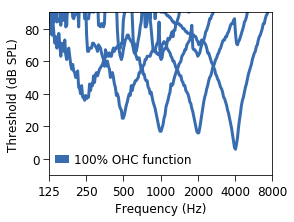

In [7]:
# PLOT ANF TUNING CURVES

fig, ax = plt.subplots(figsize=(4, 3))

color_list = util_figures.get_color_list(8, cmap_name='Accent')
dict_kwargs_plot = {
    'ohc_loss': {'c': color_list[5], 'label': '0% OHC function', 'lw': 3},
    'human': {'c': color_list[4], 'label': '100% OHC function', 'zorder': 1, 'lw': 3},
#     'narrow': {'c': '#5ab4ac', 'label': '2x narrower BWs', 'zorder': 0, 'lw': 2},
#     'human': {'c': 'k', 'label': 'Human filter BWs', 'zorder': 1, 'lw': 2},
#     'broad': {'c': '#a6611a', 'label': '2x broader BWs', 'zorder': -1, 'lw': 2},
#     'linear': {'c': '#f768a1', 'label': 'Linearly spaced', 'lw': 2},
}

list_keys_to_plot = [
#     'human',
#     'narrow',
#     'broad',
    
#     'human',
#     'linear',
    
#     'ohc_loss',
    'human',
]

for key in list_keys_to_plot:
    for itr0, list_thresholds in enumerate(dict_results[key]):
        if itr0 > 0:
            dict_kwargs_plot[key]['label'] = None
        ax.plot(list_f0, list_thresholds, **dict_kwargs_plot[key])

xticks = [list_cf[0]/2] + list_cf + [list_cf[-1]*2]
if 'ohc_loss' in list_keys_to_plot:
    ylimits = [-10, 90]
else:
    ylimits = [-10, 90]
ax = util_figures.format_axes(
    ax,
    xscale='log',
    str_xlabel='Frequency (Hz)',
    str_ylabel='Threshold (dB SPL)',
    str_title=None,
    xticks=xticks,
    xticklabels=np.array(xticks).astype(int),
    xticks_minor=[],
    xlimits=[xticks[0], xticks[-1]],
    ylimits=ylimits)
legend_plot_kwargs = {
    'loc': 'lower left',
    'ncol': 1,
    'borderpad': 0.4,
    'borderaxespad': 0.4,
    'handletextpad': 0.8,
    'frameon': False,
    'handlelength': 0.5,
    'markerscale': 1.0,
    'fontsize': 12,
}
leg = ax.legend(**legend_plot_kwargs)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)
plt.show()

# fig.savefig('tmp.pdf', bbox_inches='tight', transparent=True, pad_inches=0)


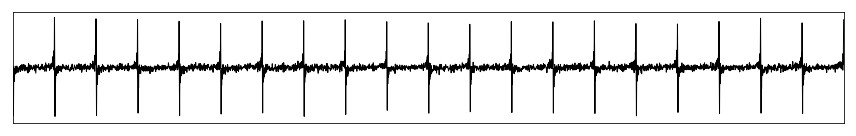

In [6]:
sr = 32000
t = np.arange(0, 0.1, 1/sr)
f0 = 200
snr = 10
dBSPL = 60
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
for freq in np.arange(f0, sr/2, f0):
    signal = signal + np.sin(2*np.pi*freq*t)
y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr)
y = util_stimuli.set_dBSPL(y, dBSPL)

figsize = (12, 2)
nrows = 1
ncols = 1
gridspec_kw = {}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=0,
    waveform=y,
    sr_waveform=sr)
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(y, rate=sr))


In [8]:
kwargs_nervegram = {
    'nervegram_dur': 0.025,
    'nervegram_fs': 20e3,
    'buffer_start_dur': 0.070,
    'buffer_end_dur': 0.000,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0,
    'cf_list': None,
    'num_cf': 100,
    'min_cf': 125,
    'max_cf': 14e3,
    'max_spikes_per_train': 500,
    'num_spike_trains': 20,
    'cohc': 1.0,
    'cihc': 1.0, #[1.0]*60 + [0.8, 0.4, 0.2, 0.1 , 0.05] + [0.05]*35,
    'IhcLowPass_cutoff': 3000,
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 0,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': False,
    'return_meanrates': True,
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': True,
    'nervegram_spike_tensor_fs': 10e3,
}

out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
for k in sorted(out_dict.keys()):
    print(k, np.array(out_dict[k]).shape)


IhcLowPass_cutoff ()
IhcLowPass_order ()
bandwidth_scale_factor (100,)
buffer_end_dur ()
buffer_start_dur ()
cf_list (100,)
cihc (100,)
cohc (100,)
implnt ()
max_spikes_per_train ()
nervegram_dur ()
nervegram_fs ()
nervegram_meanrates (100, 500)
nervegram_spike_tensor_dense (20, 100, 250)
nervegram_spike_tensor_fs ()
noiseType ()
num_spike_trains ()
pin (2500,)
pin_dBSPL ()
pin_dBSPL_flag ()
pin_fs ()
signal (800,)
signal_fs ()
species ()
spont ()
synapseMode ()
tabs ()
trel ()


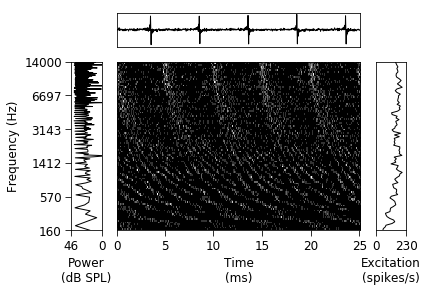

In [11]:
figsize=(6, 4)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 5],
}

waveform = out_dict['signal']
sr_waveform = out_dict['signal_fs']
# nervegram = out_dict['nervegram_meanrates']
# sr_nervegram = out_dict['nervegram_fs']
nervegram = np.sum(out_dict['nervegram_spike_tensor_dense'], axis=0)
sr_nervegram = out_dict['nervegram_spike_tensor_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=waveform,
    nervegram=nervegram,
    sr_waveform=sr_waveform,
    sr_nervegram=sr_nervegram,
    cfs=out_dict['cf_list'],
    n_anf=out_dict['nervegram_spike_tensor_dense'].shape[0])
plt.show()

# fig.savefig('tmp.png', dpi=600, bbox_inches='tight', transparent=True, pad_inches=0)


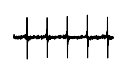

In [15]:
figsize = (1.8, 0.9)
tmin = 0.0
tmax = 0.05
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = util_figures.make_stimulus_summary_plot(
    ax,
    ax_idx_waveform=0,
    ax_idx_spectrum=None,
    ax_idx_nervegram=None,
    ax_idx_excitation=None,
    waveform=waveform,
    nervegram=None,
    sr_waveform=sr_waveform,
    sr_nervegram=None,
    cfs=out_dict['cf_list'],
    tmin=tmin,
    tmax=tmax,
    treset=True,
    vmin=None,
    vmax=None,
    spines_to_hide_waveform=['top', 'bottom', 'left', 'right'],
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    nxticks=6,
    nyticks=6,
    kwargs_plot={},
    limits_buffer=0.1,
    ax_arr_clear_leftover=True)
plt.show()

# fig.savefig('tmp.png', dpi=600, bbox_inches='tight', transparent=True, pad_inches=0)


In [ ]:
sr = 20e3
t = np.arange(0, 0.150, 1/sr)
f0 = 500
dBSPL = 60
y = util_stimuli.set_dBSPL(np.sin(2*np.pi*f0*t), dBSPL)

kwargs_nervegram = {
    'nervegram_dur': 0.010,
    'nervegram_fs': sr,
    'buffer_start_dur': 0.070,
    'buffer_end_dur': 0.010,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0,
    'cf_list': None,
    'num_cf': 1,
    'min_cf': f0,
    'max_cf': f0,
    'max_spikes_per_train': 500,
    'num_spike_trains': 20,
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3000,
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 0,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': 858,
    'return_vihcs': True,
    'return_meanrates': True,
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': True,
    'nervegram_spike_tensor_fs': sr,
}

out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)


In [ ]:
gridspec_kw = {
    'hspace': 0.15,
    'height_ratios': [1, 6, 1],
}
fig, ax = plt.subplots(figsize=(3, 3.6), ncols=1, nrows=3, gridspec_kw=gridspec_kw)

t = np.arange(0, out_dict['signal'].shape[0]) / out_dict['signal_fs']
ax[0].plot(t, out_dict['nervegram_vihcs'][0], color='k', lw=2)

y_time = np.arange(0, out_dict['nervegram_spike_tensor_dense'].shape[-1]) / out_dict['nervegram_spike_tensor_fs']
y_sum = np.zeros_like(y_time)
y_sum_all = np.zeros_like(y_time)
for itr_fiber in range(out_dict['nervegram_spike_tensor_dense'].shape[0]):
    y = 0.9 * (out_dict['nervegram_spike_tensor_dense'][itr_fiber, 0, :])
    y_sum_all = y_sum_all + y
    if (itr_fiber + 3) % 4 == 0:
#     if (itr_fiber + 3) % 1 == 0:
        y_sum = y_sum + y
        ax[1].plot(y_time, y + itr_fiber, color='k', lw=1)
    else:
        ax[1].plot(y_time, y + itr_fiber, color='k', lw=1, alpha=0)

ax[2].plot(y_time, y_sum_all, color='k', lw=2, alpha=0)
ax[2].plot(y_time, y_sum, color='k', lw=2)

for axi in ax:
    ax = util_figures.format_axes(
        axi,
        str_xlabel=None,
        str_ylabel=None,
        str_title=None,
        xticks=[],
        xticklabels=[],
        xticks_minor=[],
        yticks=[],
        yticklabels=[],
        yticks_minor=[],
        xlimits=[y_time[0], y_time[-1]],
        ylimits=None,
        spines_to_hide=['left', 'right', 'top', 'bottom']
    )
plt.show()

# fig.savefig('tmp.pdf', bbox_inches='tight', transparent=True, pad_inches=0)


In [ ]:
pin_fs = 100e3
t = np.arange(0, 0.020, 1/pin_fs)
cf = 500
dBSPL = 60
pin = util_stimuli.set_dBSPL(np.sin(2*np.pi*cf*t), dBSPL)

vihc = cython_bez2018.run_ihc(
    pin,
    pin_fs,
    cf)

synapse_out = cython_bez2018.run_synapse(
    vihc,
    pin_fs,
    cf)


fig, ax = plt.subplots(figsize=(12, 8), ncols=1, nrows=4)
ax[0].plot(t, pin, color='k')
ax[1].plot(t, vihc, color='k')
ax[2].plot(t, synapse_out['synout'], color='k')
ax[3].plot(t, synapse_out['meanrate'], color='k')
list_ylabel = ['Pressure', 'V_ihc', 'S_out', 'Spikes/s']
for itr_ax, axi in enumerate(ax):
    ax = util_figures.format_axes(
        axi,
        str_xlabel=None,
        str_ylabel=list_ylabel[itr_ax],
        str_title=None,
#         xticks=[],
#         xticklabels=[],
#         xticks_minor=[],
#         yticks=[],
#         yticklabels=[],
#         yticks_minor=[],
        xlimits=[t[0], t[-1]],
        ylimits=None,
#         spines_to_hide=['left', 'right', 'top', 'bottom']
    )
plt.tight_layout()
plt.show()
